In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

## 1. Load Data
Memuat dataset dari file CSV dan menampilkan informasi dasar tentang data seperti tipe data dan jumlah nilai yang hilang.

In [ ]:
# Load data
df = pd.read_csv("sentiment.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5400 entries, Computers and Laptops to Household
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Product Name     5400 non-null   object 
 1   Location         5400 non-null   object 
 2   Price            5400 non-null   int64  
 3   Overall Rating   5400 non-null   float64
 4   Number Sold      5400 non-null   int64  
 5   Total Review     5400 non-null   int64  
 6   Customer Rating  5400 non-null   int64  
 7   Customer Review  5400 non-null   object 
 8   Sentiment        5400 non-null   object 
 9   Emotion          5400 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 464.1+ KB


Menampilkan statistik deskriptif untuk kolom bertipe objek.

In [23]:
df.describe(include='O')

,Product Name,Location,Customer Review,Sentiment,Emotion
count,5400,5400,5400,5400,5400
unique,1308,61,5305,2,5
top,Minigold Black Series Logam Mulia Koin Emas Mi...,Jakarta Barat,jelek,Negative,Happy
freq,25,1293,4,2821,1770


Menampilkan 5 baris pertama dari dataset untuk melihat data.

In [24]:
df.head()

,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
Category,,,,,,,,,,
Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


## 2. Selecting Necessary Columns and Dropping NaN Values
Memilih kolom yang relevan ('Customer Review' dan 'Sentiment') dan menghapus data yang hilang (NaN).

In [25]:
# Selecting necessary columns and dropping NaN values
data = df[['Customer Review', 'Sentiment']].dropna()

## 3. Visualizing Sentiment Distribution and WordCloud
Menggambarkan distribusi sentimen dalam data menggunakan grafik batang.

C:\Users\USer\AppData\Local\Temp\ipykernel_1600\3422173201.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Sentiment', palette='viridis')


Text(0.5, 1.0, 'Sentiment Distribution')

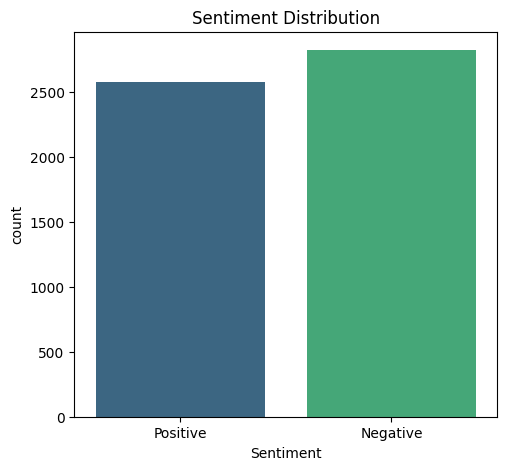

In [26]:
# Visualize distribution of Sentiment and Emotion
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=data, x='Sentiment', palette='viridis')
plt.title("Sentiment Distribution")

Membuat wordcloud dari ulasan pelanggan untuk melihat kata-kata yang paling sering muncul.

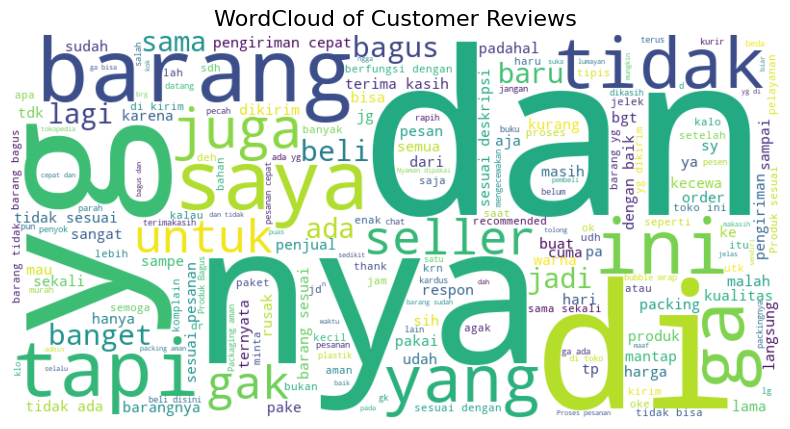

In [27]:
# Generate a wordcloud for customer reviews
text = ' '.join(data['Customer Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Customer Reviews", fontsize=16)
plt.show()

## 4. Splitting Data into Training and Testing Sets
Membagi data menjadi fitur (X) dan label (y), kemudian membagi data menjadi data pelatihan dan data pengujian.

In [ ]:
# Splitting the data
X = data['Customer Review']
y_sentiment = data['Sentiment']

# Splitting data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_sentiment, test_size=0.3, random_state=42, stratify=y_sentiment
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

## 5. Text Preprocessing
Fungsi untuk membersihkan teks: mengubah ke huruf kecil, menghapus tanda baca, menghapus angka, dan spasi ekstra.

In [ ]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove whitespace
    return text

# Menerapkan fungsi preprocessing pada data pelatihan dan pengujian.
X_train_sentiment = X_train_sentiment.apply(preprocess_text)
X_test_sentiment = X_test_sentiment.apply(preprocess_text)

## 6. Tokenization and Padding

Tokenisasi teks untuk mengonversinya menjadi urutan angka berdasarkan frekuensi kata dalam data pelatihan.

In [ ]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_sentiment)

# Mengonversi teks menjadi urutan angka.
X_train_sentiment_seq = tokenizer.texts_to_sequences(X_train_sentiment)
X_test_sentiment_seq = tokenizer.texts_to_sequences(X_test_sentiment)

# Padding untuk memastikan semua urutan teks memiliki panjang yang konsisten.
max_len = 100
X_train_sentiment_pad = pad_sequences(X_train_sentiment_seq, maxlen=max_len, padding='post')
X_test_sentiment_pad = pad_sequences(X_test_sentiment_seq, maxlen=max_len, padding='post')

## 7. Label Encoding
Mengonversi label sentimen menjadi angka menggunakan LabelEncoder.

In [ ]:
# Encode labels
label_encoder_sentiment = LabelEncoder()
y_train_sentiment_enc = label_encoder_sentiment.fit_transform(y_train_sentiment)
y_test_sentiment_enc = label_encoder_sentiment.transform(y_test_sentiment)

In [ ]:
# Model dengan validasi
X_train, X_temp, y_train, y_temp = train_test_split(input_sequences, target_sequences, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Padding target sequences untuk validasi dan testing
y_train = pad_sequences(y_train, maxlen=max_input_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_input_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_input_len, padding='post')

# Menampilkan ukuran dataset
print(f"Training data: {len(X_train)}")
print(f"Validation data: {len(X_val)}")
print(f"Testing data: {len(X_test)}")

## 8. Build the LSTM Model
Membangun model menggunakan LSTM (Long Short-Term Memory) dengan lapisan Bidirectional untuk menangkap informasi konteks.

In [ ]:
# Build the LSTM model
def build_model(output_dim):
    model = Sequential()
    
    # Embedding layer untuk mengonversi kata-kata menjadi representasi vektor.
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    
    # Menambahkan LSTM Bidirectional pertama dengan dropout untuk mencegah overfitting.
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    
    # Menambahkan LSTM Bidirectional kedua.
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    
    # Lapisan Dense untuk menghasilkan output kelas sentimen.
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    
    # Menggunakan optimizer Adam dengan learning rate yang lebih rendah untuk kestabilan.
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Membangun model untuk memastikan lapisan-lapisan terinisialisasi dengan benar.
    model.build(input_shape=(None, max_len))  # Ensures layers are built correctly
    return model

# Sentiment Model
sentiment_model = build_model(output_dim=len(label_encoder_sentiment.classes_))
print("Sentiment Model Summary:")
sentiment_model.summary()

Sentiment Model Summary:


e:\Software\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075,906 (4.10 MB)

 Trainable params: 1,075,906 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

## 9. Fit the Model
Melatih model menggunakan data pelatihan dan validasi.

In [ ]:
# Fit models
history_sentiment = sentiment_model.fit(
    X_train_sentiment_pad, y_train_sentiment_enc,
    validation_data=(X_test_sentiment_pad, y_test_sentiment_enc),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.6924 - loss: 0.5313 - val_accuracy: 0.9333 - val_loss: 0.1752
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 351ms/step - accuracy: 0.9591 - loss: 0.1251 - val_accuracy: 0.9287 - val_loss: 0.1926
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 224ms/step - accuracy: 0.9859 - loss: 0.0489 - val_accuracy: 0.9426 - val_loss: 0.1903
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 221ms/step - accuracy: 0.9900 - loss: 0.0390 - val_accuracy: 0.9380 - val_loss: 0.2568
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 0.9922 - loss: 0.0281 - val_accuracy: 0.9407 - val_loss: 0.2186
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 0.9941 - loss: 0.0163 - val_accuracy: 0.9333 - val_loss: 0.3038
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.9958 - loss: 0.0181 - val_accuracy: 0.9231 - val_loss: 0.3499
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 51s 378ms/step - accuracy: 0.9976 - loss: 0

## 10. Plot Training History
Untuk memvisualisasikan memplot akurasi dan loss selama pelatihan.

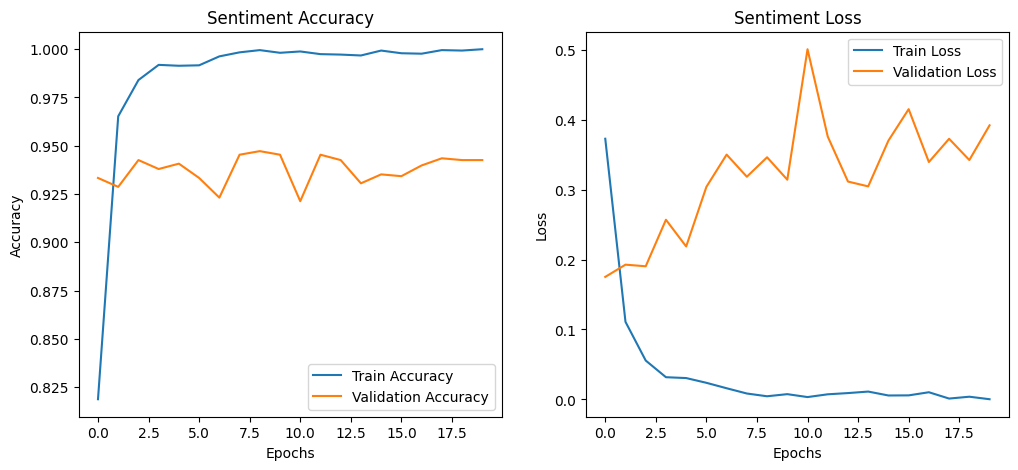

In [ ]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Memvisualisasikan akurasi dan loss untuk model sentimen.
plot_history(history_sentiment, 'Sentiment')

## 11. Model Evaluation
Mengevaluasi model menggunakan classification report dan confusion matrix.

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
Classification Report for Sentiment:

              precision    recall  f1-score   support

    Negative       0.94      0.95      0.94       557
    Positive       0.95      0.93      0.94       523

    accuracy                           0.94      1080
   macro avg       0.94      0.94      0.94      1080
weighted avg       0.94      0.94      0.94      1080



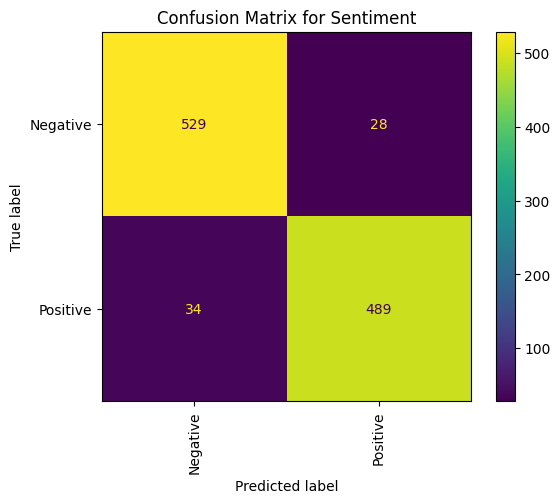

In [ ]:
# Classification report and confusion matrix
def evaluate_model(model, X_test, y_test, label_encoder, title):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Evaluate Sentiment Model
evaluate_model(sentiment_model, X_test_sentiment_pad, y_test_sentiment_enc, label_encoder_sentiment, "Sentiment")